**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

# Part I: Agents

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/agents_guide.ipynb](guides/agents_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `agents_guide` notebook to create your own RAG system.

<br>

***

### Set Up

In [1]:
# langgraph/langchain libraries
from langgraph.prebuilt import create_react_agent
from langchain_ibm import ChatWatsonx
from langchain_ibm import WatsonxEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import DuckDuckGoSearchResults

# misc libraries
import requests
from decouple import config

In [2]:
import json

json_file_path = "/Users/henrikjacobsen/Desktop/CBS/Semester 2/Artifical Intelligence and Machine Learning/apikey.json"

with open(json_file_path, "r") as file:
    data = json.load(file)

WX_API_KEY = data.get("apikey")

if WX_API_KEY:
    print("API Key loaded successfully!")
else:
    print("Error: API Key not found in JSON file.")

WX_PROJECT_ID = "0a2386df-d12c-40ee-bda2-190a5c6cc1fd"
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

API Key loaded successfully!


In [3]:
chat_model = ChatWatsonx(
    url=WX_API_URL,
    apikey=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    model_id="mistralai/mistral-large",
)

### Agent Architecture 

In [4]:
@tool
def add(a: float, b: float) -> float:
    """Add a and b."""
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract a and b."""
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b

# and to make it a little more interesting, let's add a currency converter
@tool
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date.

    Uses the Frankfurter API (https://api.frankfurter.app/) to obtain
    exchange rate data.

    Args:
        currency_from: The base currency (3-letter currency code).
            Defaults to "USD" (US Dollar).
        currency_to: The target currency (3-letter currency code).
            Defaults to "EUR" (Euro).
        currency_date: The date for which to retrieve the exchange rate.
            Defaults to "latest" for the most recent exchange rate data.
            Can be specified in YYYY-MM-DD format for historical rates.

    Returns:
        dict: A dictionary containing the exchange rate information.
            Example: {"amount": 1.0, "base": "USD", "date": "2023-11-24",
                "rates": {"EUR": 0.95534}}
    """
    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()


tools = [add, subtract, multiply, divide, get_exchange_rate]

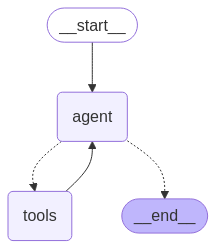

In [5]:
graph = create_react_agent(chat_model, tools=tools, debug=True)

graph

In [6]:
inputs = {
    "messages": [
        (
            "user", "I have 833 USD and my sister has 38 USD. How much do we have total in euros?"
        )
    ]
}

# we set the debug flag to True to print tasks and their results
response = graph.invoke(inputs, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'I have 833 USD and my sister has 38 USD. How much do we have '
               'total in euros?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'I have 833 USD and my sister has 38 USD. How much do we have total in '
  'euros?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='5fa34983-97c6-4120-b9f4-5daef98a7f15')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='5fa34983-97c6-4120-b9f4-5daef98a7f15')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with wr

In [7]:
response

{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='5fa34983-97c6-4120-b9f4-5daef98a7f15'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kjevBnd61', 'type': 'function', 'function': {'name': 'add', 'arguments': '{"a": 833, "b": 38}'}}, {'id': '7inYUM2Rb', 'type': 'function', 'function': {'name': 'get_exchange_rate', 'arguments': '{"currency_from": "USD", "currency_to": "EUR"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 627, 'total_tokens': 688}, 'model_name': 'mistralai/mistral-large', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-1094994000fe578f2a5b3dc9c2da6b5a', tool_calls=[{'name': 'add', 'args': {'a': 833, 'b': 38}, 'id': 'kjevBnd61', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'currency_from': 'USD', 'currency_to': 'EUR'}, 'id': '7inYUM2Rb', 'type': 'tool_call'}], usage_m

### Adding RAG

In [8]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

In [9]:
vectordb = Chroma(collection_name="my_collection", persist_directory="my_vector_db", embedding_function=watsonx_embedding)

vectordb.get(limit=1)

{'ids': ['7d0c5d49-be5f-4435-8f95-b8d4f66d9e1a'],
 'embeddings': None,
 'documents': ['[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'],
 'uris': None,
 'data': None,
 'metadatas': [{'Header 1': 'About MadeUpCompany'}],
 'included': [<IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [ ]:
retriever_tool = create_retriever_tool(
    vectordb.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": 5,
        }
    ),
    "retrieve_company_information",
    "Search and return information about MadeUpCompany",
)

tools_for_agent = [get_exchange_rate, retriever_tool]

In [ ]:
# Use the vectorstore as a retriever
retriever = vectordb.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5,
    }
)

retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

In [12]:
retrieved_documents

[Document(id='aec650f1-8773-47f6-bc12-ce85306f66fc', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Refund and Cancellation Policy'}, page_content="[About MadeUpCompany/Refund and Cancellation Policy]: \nWe stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  \nIf you're not satisfied, you can request a full refund within the first 30 days.\nAfter 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.\nEnterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.\nUpcoming Features"),
 Document(id='390ce3e4-1b00-448f-a8ed-26134e566a00', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Refund and Cancellation Policy'}, page_content="[About MadeUpCompany/Refund and Cancellation Policy]: \nWe stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  \nIf you're not satisfied, you can re

In [13]:
graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [14]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is CloudMate from MadeUpCompany? Keep it short and simple."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is CloudMate from MadeUpCompany? Keep it short and '
               'simple.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'What is CloudMate from MadeUpCompany? Keep it short and simple.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='f7feb152-19c3-415e-af50-f80ffeb68394')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='f7feb152-19c3-415e-af50-f80ffeb68394')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', add

In [15]:
response["messages"][-1].content

' CloudMate is a secure and scalable cloud storage solution designed for businesses of all sizes. It features seamless data migration with automated backups, military-grade encryption, and AI-powered file organization. Pricing plans include Basic at $9.99/month for 100GB, Professional at $29.99/month for 1TB, and Enterprise with custom pricing for unlimited storage.'

In [16]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is the price of CloudMate Professional? Find the price first and then convert it to euros."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is the price of CloudMate Professional? Find the price '
               'first and then convert it to euros.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'What is the price of CloudMate Professional? Find the price first and then '
  'convert it to euros.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='1c845568-7baf-4b52-880e-5170c2242d9f')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='1c845568-7baf-4b52-880e

In [17]:
print(response["messages"][-1].content)

 The price of CloudMate Professional is $29.99 per month. The current exchange rate from USD to EUR is 0.88308. Consequently, the price in euros would be approximately 26.47 EUR per month.


### Adding search tool

In [18]:
search_tool = DuckDuckGoSearchResults()

In [19]:
tools_for_agent = [get_exchange_rate, retriever_tool, search_tool]

graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [20]:
response = graph.invoke(
    {
        "messages": [
            (
                "user", "Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then convert it to euros."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Compare the price of CloudMate Professional from MadeUpCompany '
               'with the price of OneDrive from Microsoft. Find the price '
               'first and then convert it to euros.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'Compare the price of CloudMate Professional from MadeUpCompany with the '
  'price of OneDrive from Microsoft. Find the price first and then convert it '
  'to euros.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='c66857d5-95a9-489e-9df9-8c93707ec701')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,

In [21]:
response["messages"][-1].content

" CloudMate Professional from MadeUpCompany costs $29.99/month and the converted amount in euros is €26.47. Microsoft's OneDrive stands at a lower price point, offering plans starting from free to more advanced options that come with Microsoft 365 subscriptions, such as the Personal package at $6.99/month for 1 TB of storage.\n\nThis comparison highlights that while CloudMate Professional provides a premium service with enhanced security and priority support, OneDrive offers significant value with its integrated Microsoft 365 plans, making it a cost-effective choice for users needing comprehensive office tools along with cloud storage."

### Calculator Tool

In [22]:
@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression and return the result."""
    try:
        result = eval(expression)
        return f"The result of '{expression}' is {result}."
    except Exception as e:
        return f"Error in calculation: {e}"

In [24]:
# Add the new tools to the existing tools list
tools_for_agent.extend([calculator])

# Recreate the agent with the updated tools
graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [25]:
response = graph.invoke(
    {
        "messages": [
            ("user", "What is 25 * 4 + 10? Use the calculator."),
        ],
    },
    debug=True,
)

response["messages"][-1].content

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'What is 25 * 4 + 10? Use the calculator.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'What is 25 * 4 + 10? Use the calculator.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is 25 * 4 + 10? Use the calculator.', additional_kwargs={}, response_metadata={}, id='1e72b2fc-39f8-44d5-b61d-ac79459efb2a')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is 25 * 4 + 10? Use the calculator.', additional_kwargs={}, response_metadata={}, id='1e72b2fc-39f8-44d5-b61d-ac79459efb2a')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4WdAFxsZx', 'type': 'function', 'function': {'name': 'calculator', 'arguments': '{"exp

" The result of '25 * 4 + 10' is 110."

### Reflections on Results and Hyperparameters

**What’s Working Well**
- Correct tool use: The agent successfully chains tool calls (e.g., addition and currency conversion) to solve multi-step queries
- Chain of reasoning: Tasks are decomposed effectively, demonstrating that the agent follows logical steps to reach answers
- Tool integration: Integration of tools such as the `get_exchange_rate` API and the vector-based retriever works reliably

**Key Hyperparameters and Their Importance**

1. `k` in Retriever (`search_kwargs={"k": 5}`)
   - Controls the number of similar documents retrieved from the vector store
   - Higher values increase recall (more relevant results), but may introduce noise and increase response time
   - In this project, `k=5` strikes a good balance, improving the coverage of retrieval without overwhelming the agent with irrelevant context

2. `model_id` (e.g., `"mistralai/mistral-large"`)
   - Determines the LLM's reasoning and planning abilities
   - Larger models generally handle complex tool orchestration and contextual synthesis better

3. Embedding model & chunking strategy
   - The embedding model (`"ibm/granite-embedding-278m-multilingual"`) influences document similarity
   - The effectiveness of retrieval also depends on how documents are chunked. Smaller, semantically meaningful chunks (e.g., by headers or paragraphs) often yield more precise results

4. Prompt formulation
   - Though not a code-level hyperparameter, the clarity of user prompts significantly impacts tool invocation and answer accuracy
   - Explicit queries (e.g., “first retrieve, then convert”) help the agent better plan its actions

**Suggestions for Further Tuning**
- Try different `k` values (e.g., `3`, `7`, `10`) to test for optimal retrieval precision and coverage
- Add metadata-based filters to narrow down retrieval scope (e.g., by section headers)
- Improve chunking of your documents for more semantically meaningful embeddings
- Add post-processing steps to polish or validate multi-tool outputs for consistency